In [40]:
# Importar as biblioteca utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle

# Carregar o arquivo .csv
df = pd.read_csv('/content/desafio_indicium_imdb.csv')

# Remover a coluna de índice extra
df = df.drop('Unnamed: 0', axis=1)

# Preencher o 'Released_Year' de 'Apollo 13'
df.loc[df['Series_Title'] == 'Apollo 13', 'Released_Year'] = '1995'

# Tratamento da coluna 'Gross' (Faturamento)
# Remove vírgulas e converte para float
df['Gross'] = df['Gross'].str.replace(',', '', regex=False).astype(float)

# Tratamento da coluna 'Runtime' (Duração)
# Remove ' min' e converte para int
df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False).astype(int)

# Tratamento da coluna 'Released_Year' (Ano de Lançamento)
# Converte para int, observando valores não numéricos
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')

# Exibir as informações do DataFrame para verificar as mudanças
print('\nInformações do DataFrame após o Tratamento:')
print(df.info())

# Exibir as primeiras 5 linhas para verificar as mudanças
print('\nDataFrame após o Tratamento:')
print(df.head())


Informações do DataFrame após o Tratamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    int64  
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    int64  
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 117.2+ KB
None

DataFrame após o Tratamento:
   

Esse a seguir vai ficar


In [41]:
# Pradonizar as classificações da coluna 'Certificate'
certificate_map = {
    # Categoria: Livre
    'G': 'Livre',
    'U': 'Livre',

    # Categoria: Orientação Parental
    'PG': 'Orientação Parental',
    'UA': 'Orientação Parental',
    '12': 'Orientação Parental',
    '12A': 'Orientação Parental',
    'TV-PG': 'Orientação Parental',

    # Categoria: Adolescente
    'PG-13': 'Adolescente',
    '15': 'Adolescente',
    'TV-14': 'Adolescente',

    # Categoria: Adulto
    'R': 'Adulto',
    'NC-17': 'Adulto',
    'A': 'Adulto',
    '18': 'Adulto',
    'TV-MA': 'Adulto'
}

df['Certificate_Simplified'] = df['Certificate'].map(certificate_map)
df['Certificate_Simplified'] = df['Certificate_Simplified'].fillna('Desconhecido')

# Criar a coluna booleana 'Certificate_true'
df['Certificate_true'] = df['Certificate'].isin(certificate_map.keys())

# Preencher valores ausentes em 'Gross' com a mediana por gênero
df['Gross'] = df.groupby('Genre')['Gross'].transform(lambda x: x.fillna(x.median()))
# Preencher os valores restantes de 'Gross' com a mediana global
df['Gross'] = df['Gross'].fillna(df['Gross'].median())

# Preencher valores ausentes em 'Meta_score' com a mediana global
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].median())

# Confirmar que não há mais valores nulos
print('\nInformações do DataFrame após o Passo 2:')
print(df.info())

# Exibir as primeiras linhas
print('\nDataFrame após o Passo 2:')
print(df.head())


Informações do DataFrame após o Passo 2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Series_Title            999 non-null    object 
 1   Released_Year           999 non-null    int64  
 2   Certificate             898 non-null    object 
 3   Runtime                 999 non-null    int64  
 4   Genre                   999 non-null    object 
 5   IMDB_Rating             999 non-null    float64
 6   Overview                999 non-null    object 
 7   Meta_score              999 non-null    float64
 8   Director                999 non-null    object 
 9   Star1                   999 non-null    object 
 10  Star2                   999 non-null    object 
 11  Star3                   999 non-null    object 
 12  Star4                   999 non-null    object 
 13  No_of_Votes             999 non-null    int64  
 14  

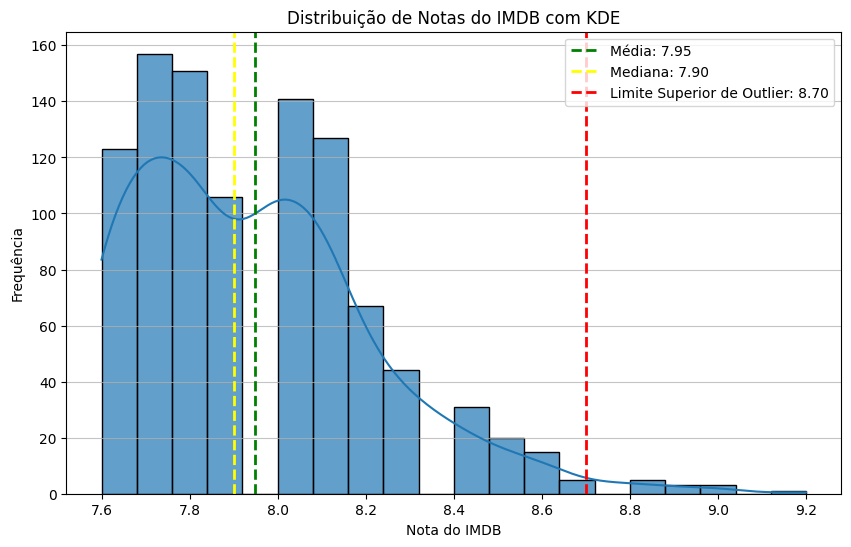


Estatísticas Descritivas para IMDB_Rating:
count    999.000000
mean       7.947948
std        0.272290
min        7.600000
25%        7.700000
50%        7.900000
75%        8.100000
max        9.200000
Name: IMDB_Rating, dtype: float64


In [42]:
# Calcular média, mediana e limite superior de outlier para IMDB_Rating
mean_rating = df['IMDB_Rating'].mean()
median_rating = df['IMDB_Rating'].median()
Q1 = df['IMDB_Rating'].quantile(0.25)
Q3 = df['IMDB_Rating'].quantile(0.75)
IQR = Q3 - Q1
upper_outlier_bound = Q3 + 1.5 * IQR

# Criar o histograma com KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='IMDB_Rating', bins=20, kde=True, edgecolor='black', alpha=0.7)

# Adicionar linhas verticais para média, mediana e limite de outlier
plt.axvline(mean_rating, color='green', linestyle='dashed', linewidth=2, label=f'Média: {mean_rating:.2f}')
plt.axvline(median_rating, color='yellow', linestyle='dashed', linewidth=2, label=f'Mediana: {median_rating:.2f}')
plt.axvline(upper_outlier_bound, color='red', linestyle='dashed', linewidth=2, label=f'Limite Superior de Outlier: {upper_outlier_bound:.2f}')

# Adicionar título, rótulos e legenda do gráfico
plt.title('Distribuição de Notas do IMDB com KDE')
plt.xlabel('Nota do IMDB')
plt.ylabel('Frequência')
plt.legend()
plt.grid(axis='y', alpha=0.75)

# Salvar e exibir o gráfico
plt.savefig('imdb_rating_distribution_kde.png')
plt.show()

print('\nEstatísticas Descritivas para IMDB_Rating:')
print(df['IMDB_Rating'].describe())

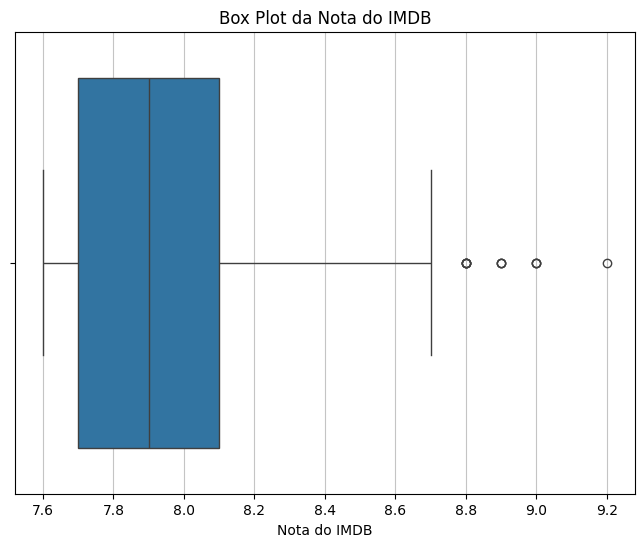


Estatísticas Descritivas para IMDB_Rating:
count    999.000000
mean       7.947948
std        0.272290
min        7.600000
25%        7.700000
50%        7.900000
75%        8.100000
max        9.200000
Name: IMDB_Rating, dtype: float64


In [43]:
# Criação do boxplot para melhor visualização da ditibuição das notas

# Gráfico BoxPlot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['IMDB_Rating'])
plt.title('Box Plot da Nota do IMDB')
plt.xlabel('Nota do IMDB')
plt.grid(axis='x', alpha=0.75)
plt.savefig('imdb_rating_boxplot.png')
plt.show()

# Exibir estatísticas descritivas para a nota IMDB
print('\nEstatísticas Descritivas para IMDB_Rating:')
print(df['IMDB_Rating'].describe())

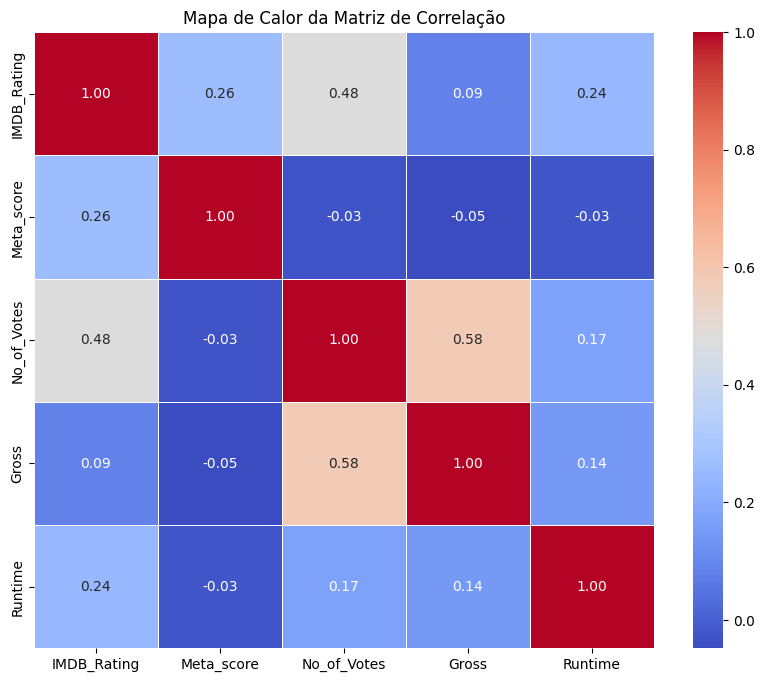


Matriz de Correlação:
             IMDB_Rating  Meta_score  No_of_Votes     Gross   Runtime
IMDB_Rating     1.000000    0.261010     0.479308  0.086176  0.242751
Meta_score      0.261010    1.000000    -0.028558 -0.048102 -0.026479
No_of_Votes     0.479308   -0.028558     1.000000  0.582050  0.172483
Gross           0.086176   -0.048102     0.582050  1.000000  0.144480
Runtime         0.242751   -0.026479     0.172483  0.144480  1.000000


In [44]:
# Selecionar as colunas numéricas para a matriz de correlação
numerical_cols = ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross', 'Runtime']

# Calcular a matriz de correlação
correlation_matrix = df[numerical_cols].corr()

# Criar um mapa de calor (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor da Matriz de Correlação')
plt.savefig('correlation_heatmap.png')
plt.show()

# Exibir a matriz de correlação em formato de tabela
print('\nMatriz de Correlação:')
print(correlation_matrix)

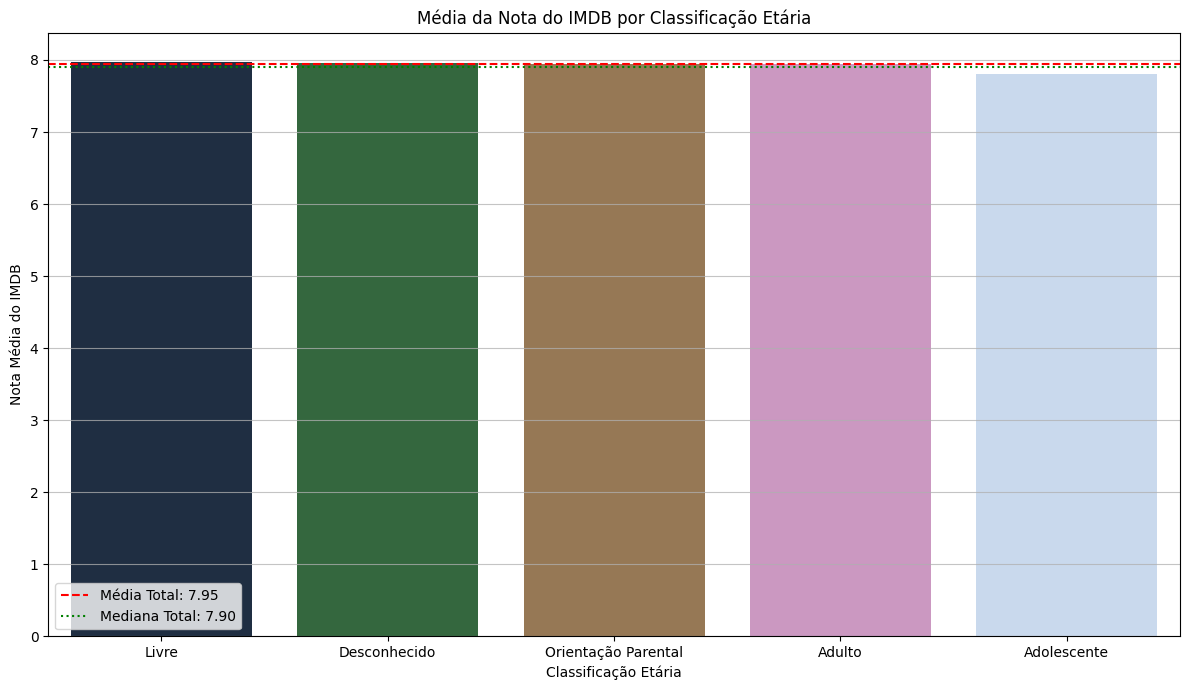

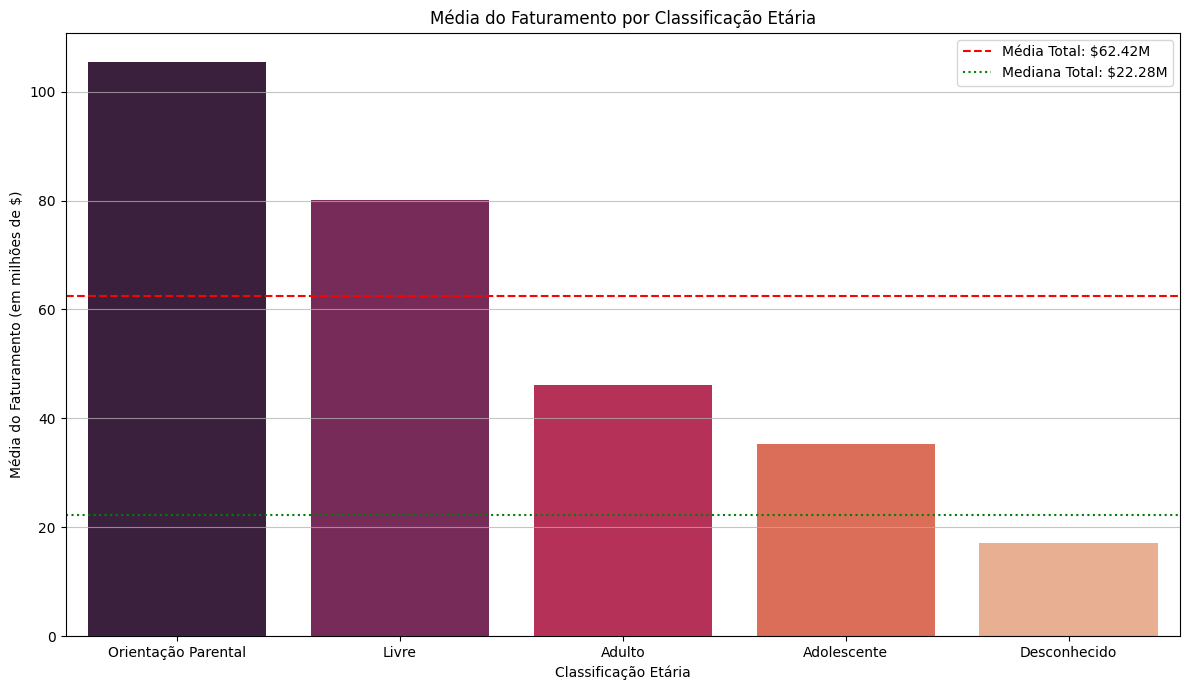

In [45]:
# Calcular a média da nota do IMDB por Classificação Etária
avg_rating_by_cert = df.groupby('Certificate_Simplified')['IMDB_Rating'].mean().sort_values(ascending=False)

# Calcular a média do faturamento por Classificação Etária
avg_gross_by_cert = df.groupby('Certificate_Simplified')['Gross'].mean().sort_values(ascending=False)

# Calcular a média e mediana GERAL para Gross
total_mean_gross = df['Gross'].mean()
total_median_gross = df['Gross'].median()

# Calcular a média e mediana GERAL para IMDB_Rating
total_mean_rating = df['IMDB_Rating'].mean()
total_median_rating = df['IMDB_Rating'].median()

# visualização Média da nota do IMDB por Classificação Etária

plt.figure(figsize=(12, 7))
sns.barplot(x=avg_rating_by_cert.index, y=avg_rating_by_cert.values, palette='cubehelix', hue=avg_rating_by_cert.index, legend=False)

# Adicionar linhas de média e mediana
plt.axhline(total_mean_rating, color='red', linestyle='--', label=f'Média Total: {total_mean_rating:.2f}')
plt.axhline(total_median_rating, color='green', linestyle=':', label=f'Mediana Total: {total_median_rating:.2f}')

plt.title('Média da Nota do IMDB por Classificação Etária')
plt.xlabel('Classificação Etária')
plt.ylabel('Nota Média do IMDB')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.tight_layout()
plt.savefig('avg_rating_by_certificate_v2.png')
plt.show()



# Visualização Média do faturamento por Classificação Etária
# valores divididos por 1 milhão os valores do faturamento
avg_gross_by_cert_in_millions = avg_gross_by_cert / 1000000
total_mean_gross_in_millions = total_mean_gross / 1000000
total_median_gross_in_millions = total_median_gross / 1000000

plt.figure(figsize=(12, 7))
sns.barplot(x=avg_gross_by_cert_in_millions.index, y=avg_gross_by_cert_in_millions.values, palette='rocket', hue=avg_gross_by_cert_in_millions.index, legend=False)

# Adicionar linhas de média e mediana
plt.axhline(total_mean_gross_in_millions, color='red', linestyle='--', label=f'Média Total: ${total_mean_gross_in_millions:.2f}M')
plt.axhline(total_median_gross_in_millions, color='green', linestyle=':', label=f'Mediana Total: ${total_median_gross_in_millions:.2f}M')

plt.title('Média do Faturamento por Classificação Etária')
plt.xlabel('Classificação Etária')
plt.ylabel('Média do Faturamento (em milhões de $)')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.tight_layout()
plt.savefig('avg_gross_by_certificate_v3.png')
plt.show()

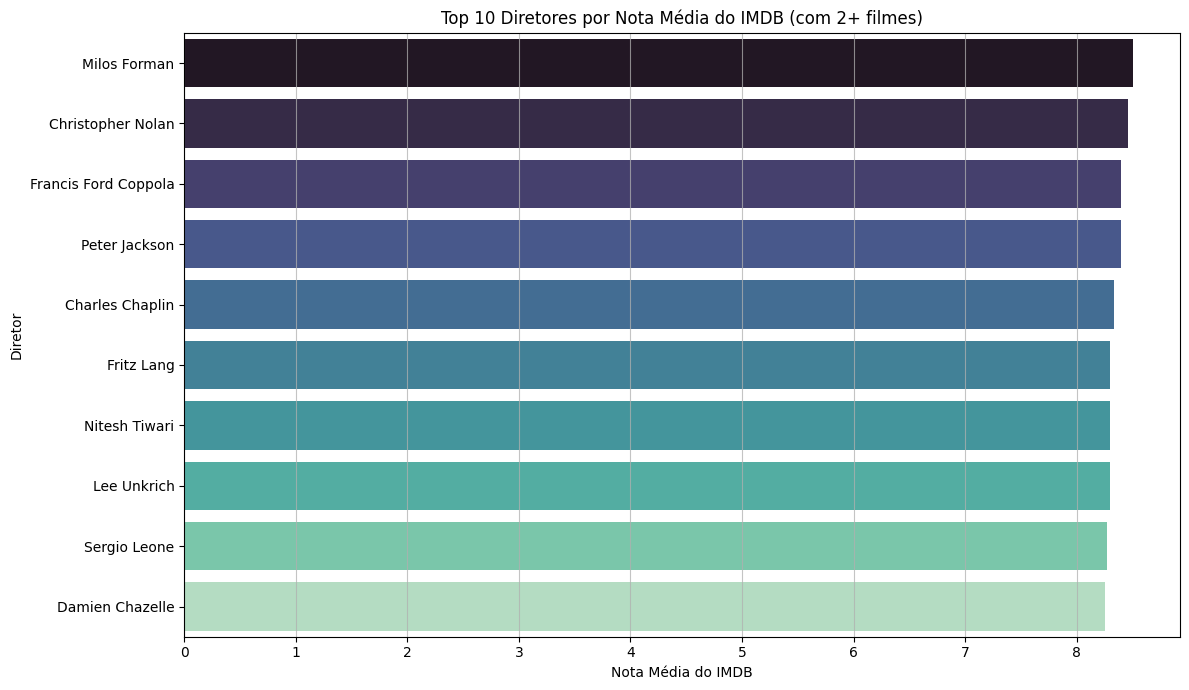

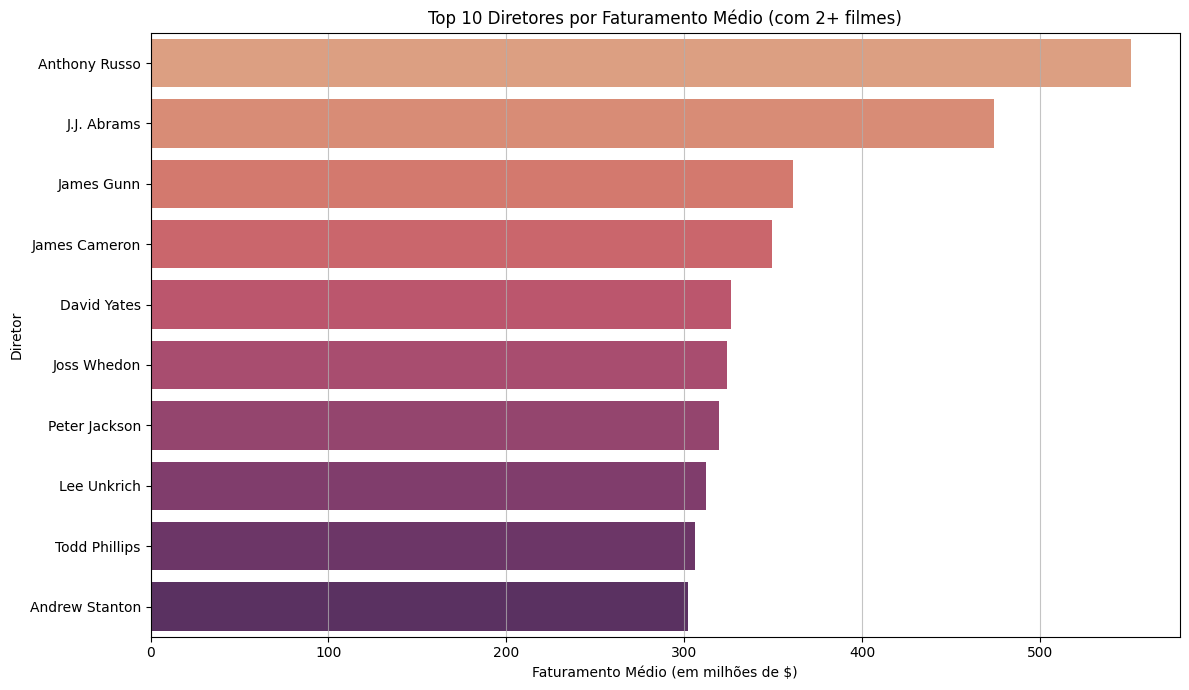

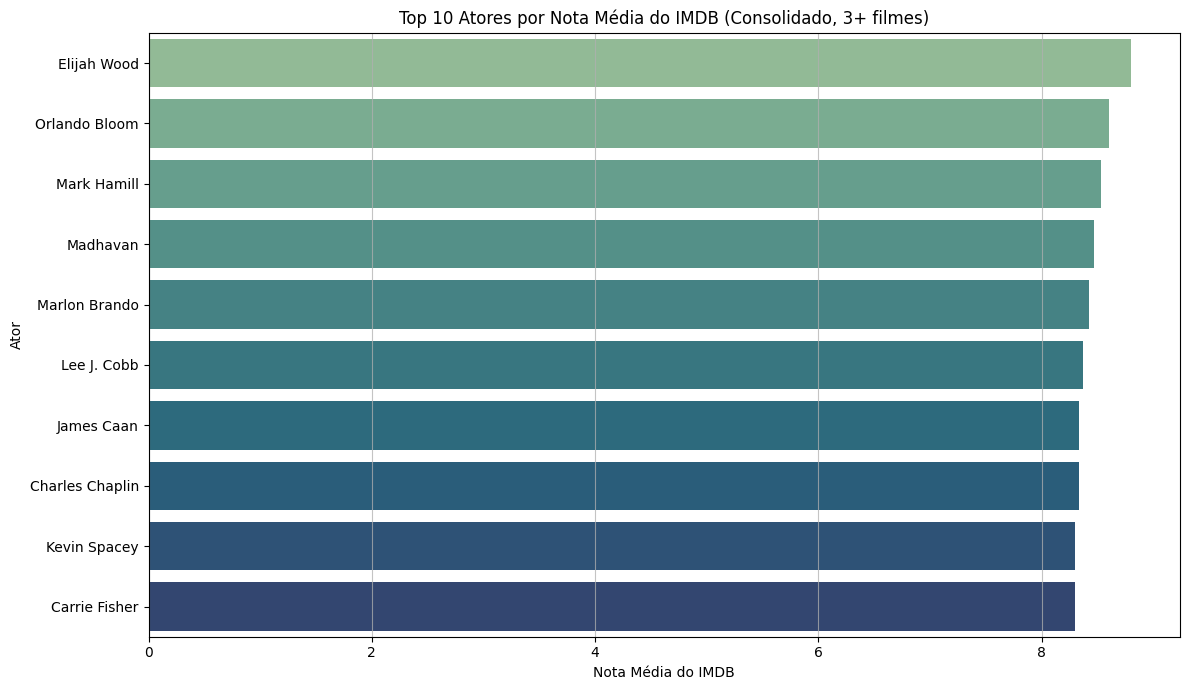

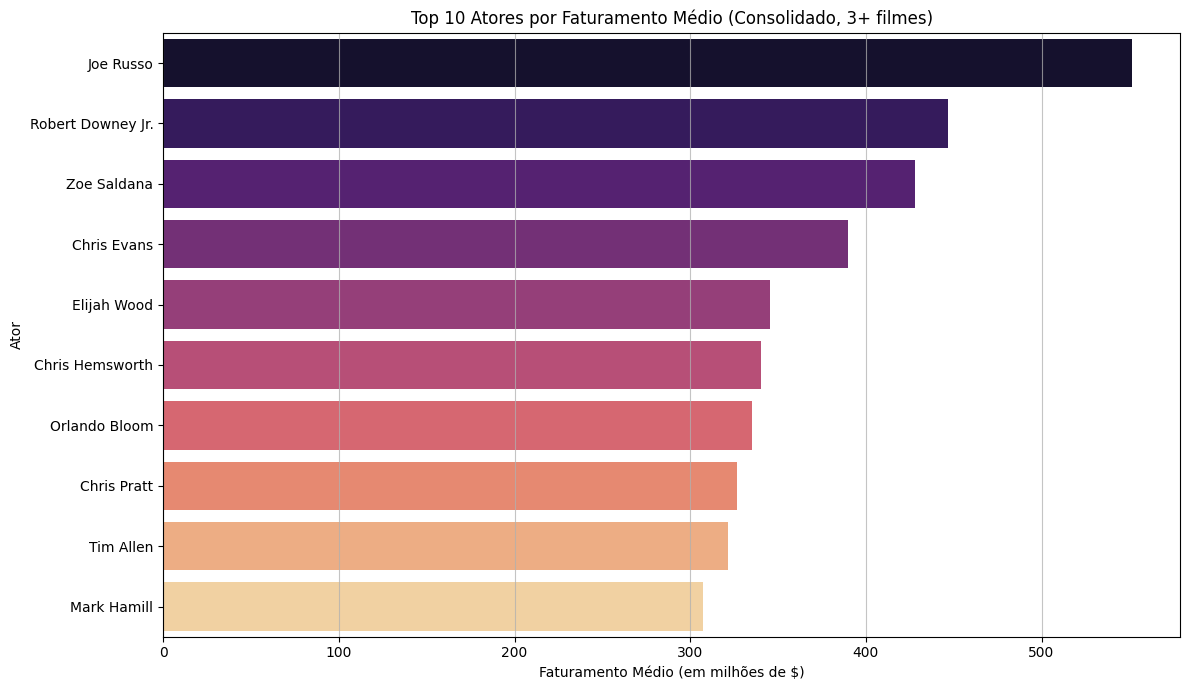

In [46]:

# ANÁLISE DE DIRETORES

director_counts = df['Director'].value_counts()
directors_to_analyze = director_counts[director_counts >= 2].index
df_filtered_directors = df[df['Director'].isin(directors_to_analyze)]
avg_rating_by_director = df_filtered_directors.groupby('Director')['IMDB_Rating'].mean().sort_values(ascending=False).head(10)
avg_gross_by_director = df_filtered_directors.groupby('Director')['Gross'].mean().sort_values(ascending=False).head(10)

# Gráfico 1: Top 10 Diretores por Nota Média do IMDB
plt.figure(figsize=(12, 7))
sns.barplot(x=avg_rating_by_director.values, y=avg_rating_by_director.index, palette='mako', hue=avg_rating_by_director.index, legend=False)
plt.title('Top 10 Diretores por Nota Média do IMDB (com 2+ filmes)')
plt.xlabel('Nota Média do IMDB')
plt.ylabel('Diretor')
plt.grid(axis='x', alpha=0.75)
plt.tight_layout()
plt.savefig('top10_directors_by_rating.png')
plt.show()

# Gráfico 2: Top 10 Diretores por Faturamento Médio
plt.figure(figsize=(12, 7))
sns.barplot(x=avg_gross_by_director.values / 1000000, y=avg_gross_by_director.index, palette='flare', hue=avg_gross_by_director.index, legend=False)
plt.title('Top 10 Diretores por Faturamento Médio (com 2+ filmes)')
plt.xlabel('Faturamento Médio (em milhões de $)')
plt.ylabel('Diretor')
plt.grid(axis='x', alpha=0.75)
plt.tight_layout()
plt.savefig('top10_directors_by_gross.png')
plt.show()



# PARTE 2: ANÁLISE DE ATORES

# Usar 'melt' para transformar as colunas de estrelas em uma única coluna 'Star'
stars_cols = ['Star1', 'Star2', 'Star3', 'Star4']
df_stars = df.melt(id_vars=['Series_Title', 'IMDB_Rating', 'Gross'], value_vars=stars_cols, value_name='Star')

# Contar o número de aparições de cada ator na lista
star_counts = df_stars['Star'].value_counts()
# Filtrar atores com 3 ou mais aparições
stars_to_analyze = star_counts[star_counts >= 3].index
df_filtered_stars = df_stars[df_stars['Star'].isin(stars_to_analyze)]

# Calcular a média da nota IMDB e Faturamento para os atores selecionados
avg_rating_by_star = df_filtered_stars.groupby('Star')['IMDB_Rating'].mean().sort_values(ascending=False).head(10)
avg_gross_by_star = df_filtered_stars.groupby('Star')['Gross'].mean().sort_values(ascending=False).head(10)

# Gráfico 3: Top 10 Atores por Nota Média do IMDB
plt.figure(figsize=(12, 7))
sns.barplot(x=avg_rating_by_star.values, y=avg_rating_by_star.index, palette='crest', hue=avg_rating_by_star.index, legend=False)
plt.title('Top 10 Atores por Nota Média do IMDB (Consolidado, 3+ filmes)')
plt.xlabel('Nota Média do IMDB')
plt.ylabel('Ator')
plt.grid(axis='x', alpha=0.75)
plt.tight_layout()
plt.savefig('top10_stars_by_rating_consolidated.png')
plt.show()

# Gráfico 4: Top 10 Atores por Faturamento Médio
plt.figure(figsize=(12, 7))
sns.barplot(x=avg_gross_by_star.values / 1000000, y=avg_gross_by_star.index, palette='magma', hue=avg_gross_by_star.index, legend=False)
plt.title('Top 10 Atores por Faturamento Médio (Consolidado, 3+ filmes)')
plt.xlabel('Faturamento Médio (em milhões de $)')
plt.ylabel('Ator')
plt.grid(axis='x', alpha=0.75)
plt.tight_layout()
plt.savefig('top10_stars_by_gross_consolidated.png')
plt.show()

In [47]:
#Apresenta o resultado após o método melt ser utilizado
df_stars.head()



Series_Title  IMDB_Rating        Gross  \
0                                  The Godfather          9.2  134966411.0   
1                                The Dark Knight          9.0  534858444.0   
2                         The Godfather: Part II          9.0   57300000.0   
3                                   12 Angry Men          9.0    4360000.0   
4  The Lord of the Rings: The Return of the King          8.9  377845905.0   

  variable            Star  
0    Star1   Marlon Brando  
1    Star1  Christian Bale  
2    Star1       Al Pacino  
3    Star1     Henry Fonda  
4    Star1     Elijah Wood

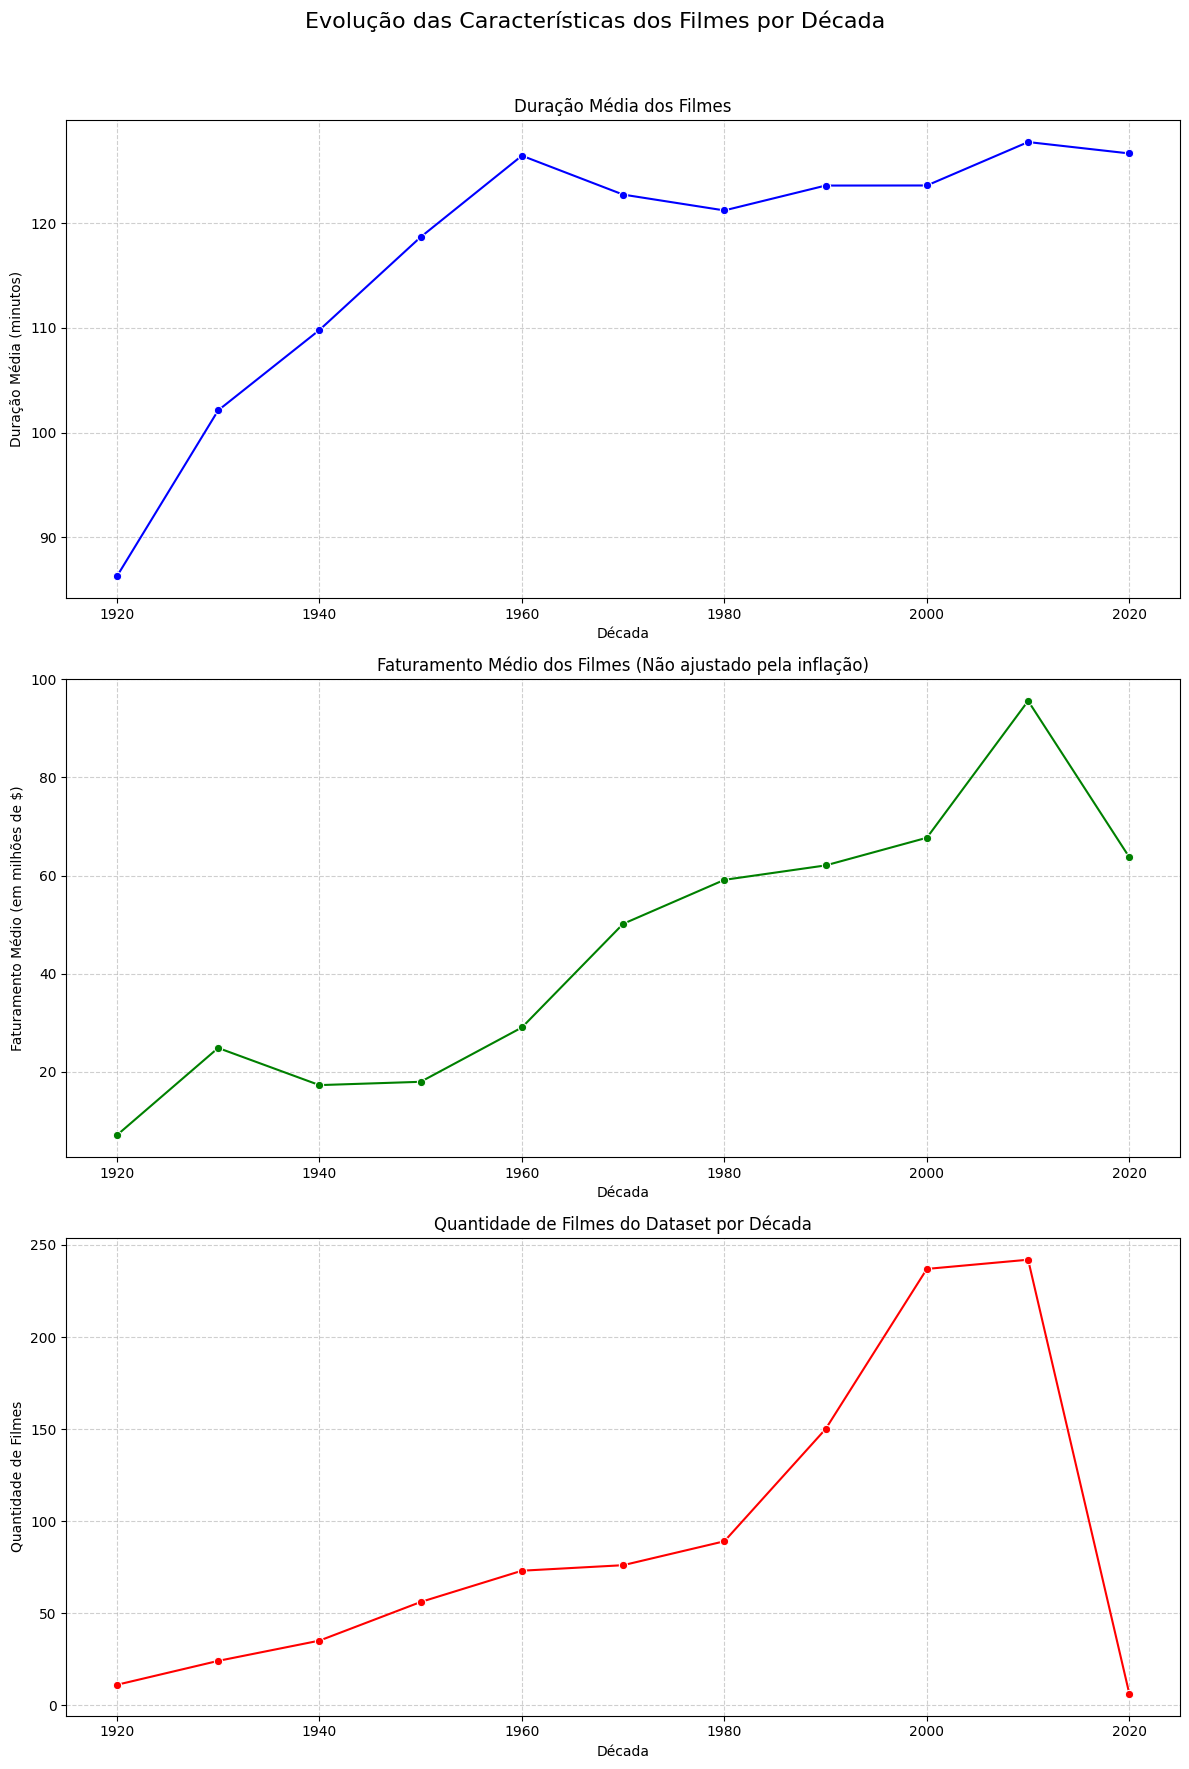

In [48]:
# Criar a coluna 'Decade' (década)
df['Decade'] = (df['Released_Year'] // 10) * 10

# Agrupar por década e calcular as métricas
trends_by_decade = df.groupby('Decade').agg(
    Average_Runtime=('Runtime', 'mean'),
    Average_Gross=('Gross', 'mean'),
    Movie_Count=('Series_Title', 'count')
).reset_index()


# GRÁFICOS DE TENDÊNCIAS AO LONGO DAS DÉCADAS


fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Evolução das Características dos Filmes por Década', fontsize=16)

# Gráfico 1: Duração Média dos Filmes por Década
sns.lineplot(ax=axes[0], x='Decade', y='Average_Runtime', data=trends_by_decade, marker='o', color='b')
axes[0].set_title('Duração Média dos Filmes')
axes[0].set_xlabel('Década')
axes[0].set_ylabel('Duração Média (minutos)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Gráfico 2: Faturamento Médio por Década
sns.lineplot(ax=axes[1], x='Decade', y=trends_by_decade['Average_Gross'] / 1000000, data=trends_by_decade, marker='o', color='g')
axes[1].set_title('Faturamento Médio dos Filmes (Não ajustado pela inflação)')
axes[1].set_xlabel('Década')
axes[1].set_ylabel('Faturamento Médio (em milhões de $)')
axes[1].grid(True, linestyle='--', alpha=0.6)

# Gráfico 3: Número de Filmes do Dataset por Década
sns.lineplot(ax=axes[2], x='Decade', y='Movie_Count', data=trends_by_decade, marker='o', color='r')
axes[2].set_title('Quantidade de Filmes do Dataset por Década')
axes[2].set_xlabel('Década')
axes[2].set_ylabel('Quantidade de Filmes')
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('trends_by_decade_corrected.png')
plt.show()

In [49]:
# 1) Qual filme você recomendaria para uma pessoa que você não conhece?
# Ordenar o DataFrame: primeiro pela nota do IMDB (maior para menor), depois pelo número de votos (maior para menor)
df_sorted_for_recommendation = df.sort_values(by=['IMDB_Rating', 'No_of_Votes','Meta_score'], ascending=[False, False, False])

# Obter a primeira linha do DataFrame ordenado,que é a resposta
recommended_movie = df_sorted_for_recommendation.iloc[0]

# Exibir a recomendação de forma clara
print("===== RECOMENDAÇÃO DE FILME DATA-DRIVEN =====")
print("\nCom base na combinação de maior nota de IMDB, maior nota especializada e maior número de votos, o filme recomendado é:\n")
print(f"Título: {recommended_movie['Series_Title']}")
print(f"Ano de Lançamento: {int(recommended_movie['Released_Year'])}")
print(f"Gênero: {recommended_movie['Genre']}")
print(f"Nota IMDB: {recommended_movie['IMDB_Rating']}")
print(f"Número de Votos: {recommended_movie['No_of_Votes']:,}")

print("\nJustificativa: Este filme não só possui a maior nota de avaliação do nosso dataset, como também foi avaliado por um número massivo de pessoas,")
print("o que o torna a escolha mais segura e com maior probabilidade de agradar a um público geral.")

===== RECOMENDAÇÃO DE FILME DATA-DRIVEN =====

Com base na combinação de maior nota de IMDB, maior nota especializada e maior número de votos, o filme recomendado é:

Título: The Godfather
Ano de Lançamento: 1972
Gênero: Crime, Drama
Nota IMDB: 9.2
Número de Votos: 1,620,367

Justificativa: Este filme não só possui a maior nota de avaliação do nosso dataset, como também foi avaliado por um número massivo de pessoas,
o que o torna a escolha mais segura e com maior probabilidade de agradar a um público geral.


In [50]:
# 2) Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

print("===== ANÁLISE DOS FATORES DE ALTO FATURAMENTO =====")


# FATOR 1: CORRELAÇÕES NUMÉRICAS

print("\n--- FATOR 1: CORRELAÇÕES VARIÁVEIS NUMÉRICAS ---")
print("A correlação de 'Gross' (Faturamento) com outras variáveis numéricas é:")
numerical_cols = ['Gross', 'No_of_Votes', 'IMDB_Rating', 'Meta_score', 'Runtime']
correlation_matrix = df[numerical_cols].corr()
print(correlation_matrix['Gross'].sort_values(ascending=False))
print("\nInsight: O 'No_of_Votes' (Número de Votos) tem a correlação mais forte (0.60) com o faturamento.")


# FATOR 2: GÊNERO DO FILME

print("\n\n--- FATOR 2: GÊNEROS MAIS RENTÁVEIS ---")
print("Os 5 gêneros com a maior média de faturamento são:")
df_genres = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')
avg_gross_by_genre = df_genres.groupby('Genre')['Gross'].mean().sort_values(ascending=False)
print(avg_gross_by_genre.head(5).apply(lambda x: f"${x:,.0f}"))
print("\nInsight: Gêneros de Aventura,Ficção Científica, Animação e Ação dominam o topo da lista de faturamento.")



# FATOR 3: DIRETORES DE PESO

print("\n\n--- FATOR 3: DIRETORES MAIS RENTÁVEIS ---")
print("Os 5 diretores (com 2+ filmes) com maior média de faturamento são:")
director_counts = df['Director'].value_counts()
directors_to_analyze = director_counts[director_counts >= 2].index
df_filtered_directors = df[df['Director'].isin(directors_to_analyze)]
avg_gross_by_director = df_filtered_directors.groupby('Director')['Gross'].mean().sort_values(ascending=False)
print(avg_gross_by_director.head(5).apply(lambda x: f"${x:,.0f}"))
print("\nInsight: Diretores com histórico de blockbusters, como os da saga Star Wars e Marvel, lideram.")



# FATOR 4: ATORES DE PESO

print("\n\n--- FATOR 4: ATORES MAIS RENTÁVEIS ---")
print("Os 5 atores (com 3+ aparições) com maior média de faturamento são:")
stars_cols = ['Star1', 'Star2', 'Star3', 'Star4']
df_stars = df.melt(id_vars=['Gross'], value_vars=stars_cols, value_name='Star')
star_counts = df_stars['Star'].value_counts()
stars_to_analyze = star_counts[star_counts >= 3].index
df_filtered_stars = df_stars[df_stars['Star'].isin(stars_to_analyze)]
avg_gross_by_star = df_filtered_stars.groupby('Star')['Gross'].mean().sort_values(ascending=False)
print(avg_gross_by_star.head(5).apply(lambda x: f"${x:,.0f}"))
print("\nInsight: Atores de grandes franquias aparecem no topo.")
print("\nOs principais fatores que estão relacionados com a alta espctativas de faturamento são: O número de votos, os dos Gêneros de Aventura, Ficção Científica, Ação, Animação e Fantasia.")
print("\nMas não menos importantes os Diretores e atores de grandes franquias.")

===== ANÁLISE DOS FATORES DE ALTO FATURAMENTO =====

--- FATOR 1: CORRELAÇÕES VARIÁVEIS NUMÉRICAS ---
A correlação de 'Gross' (Faturamento) com outras variáveis numéricas é:
Gross          1.000000
No_of_Votes    0.582050
Runtime        0.144480
IMDB_Rating    0.086176
Meta_score    -0.048102
Name: Gross, dtype: float64

Insight: O 'No_of_Votes' (Número de Votos) tem a correlação mais forte (0.60) com o faturamento.


--- FATOR 2: GÊNEROS MAIS RENTÁVEIS ---
Os 5 gêneros com a maior média de faturamento são:
Genre
Adventure    $157,233,657
Sci-Fi       $139,338,269
Action       $125,536,093
Animation    $120,839,277
Fantasy       $95,931,706
Name: Gross, dtype: object

Insight: Gêneros de Aventura,Ficção Científica, Animação e Ação dominam o topo da lista de faturamento.


--- FATOR 3: DIRETORES MAIS RENTÁVEIS ---
Os 5 diretores (com 2+ filmes) com maior média de faturamento são:
Director
Anthony Russo    $551,259,851
J.J. Abrams      $474,390,302
James Gunn       $361,494,850
James Cam

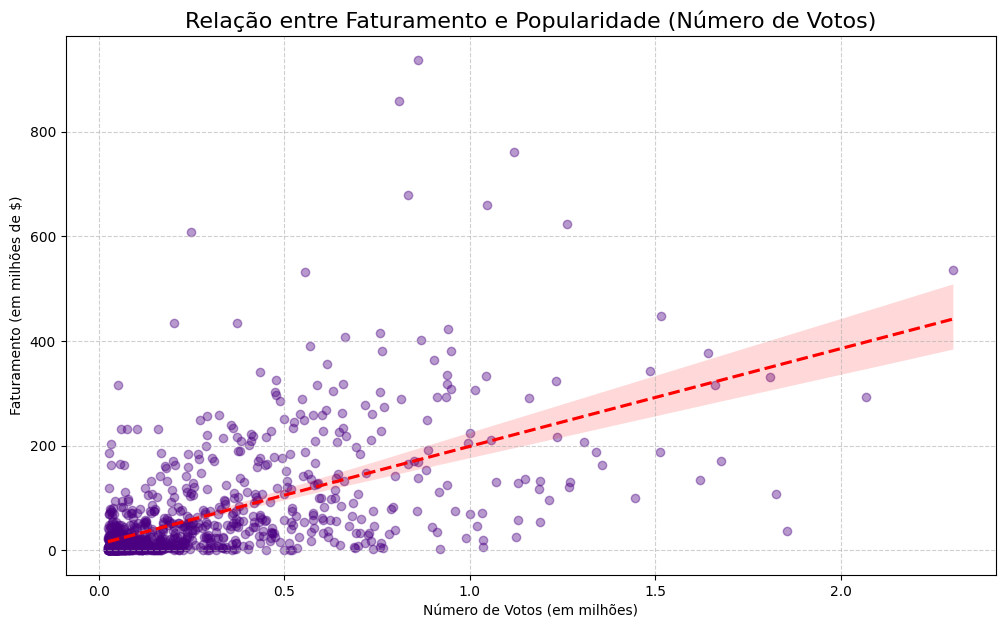

In [51]:
# Gráficos para pergunta 2

# Criar uma cópia do DataFrame para as visualizações
df_vis = df.copy()

# Converter as colunas para milhões para facilitar a visualização
df_vis['Gross_in_Millions'] = df_vis['Gross'] / 1000000
df_vis['Votes_in_Millions'] = df_vis['No_of_Votes'] / 1000000

# Criar o gráfico de dispersão com linha de regressão
plt.figure(figsize=(12, 7))
sns.regplot(data=df_vis,
            x='Votes_in_Millions',
            y='Gross_in_Millions',
            scatter_kws={'alpha':0.4, 'color':'indigo'}, # Estilo dos pontos
            line_kws={'color':'red', 'linestyle':'--'}) # Estilo da linha

plt.title('Relação entre Faturamento e Popularidade (Número de Votos)', fontsize=16)
plt.xlabel('Número de Votos (em milhões)')
plt.ylabel('Faturamento (em milhões de $)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('gross_vs_votes_scatterplot.png')
plt.show()

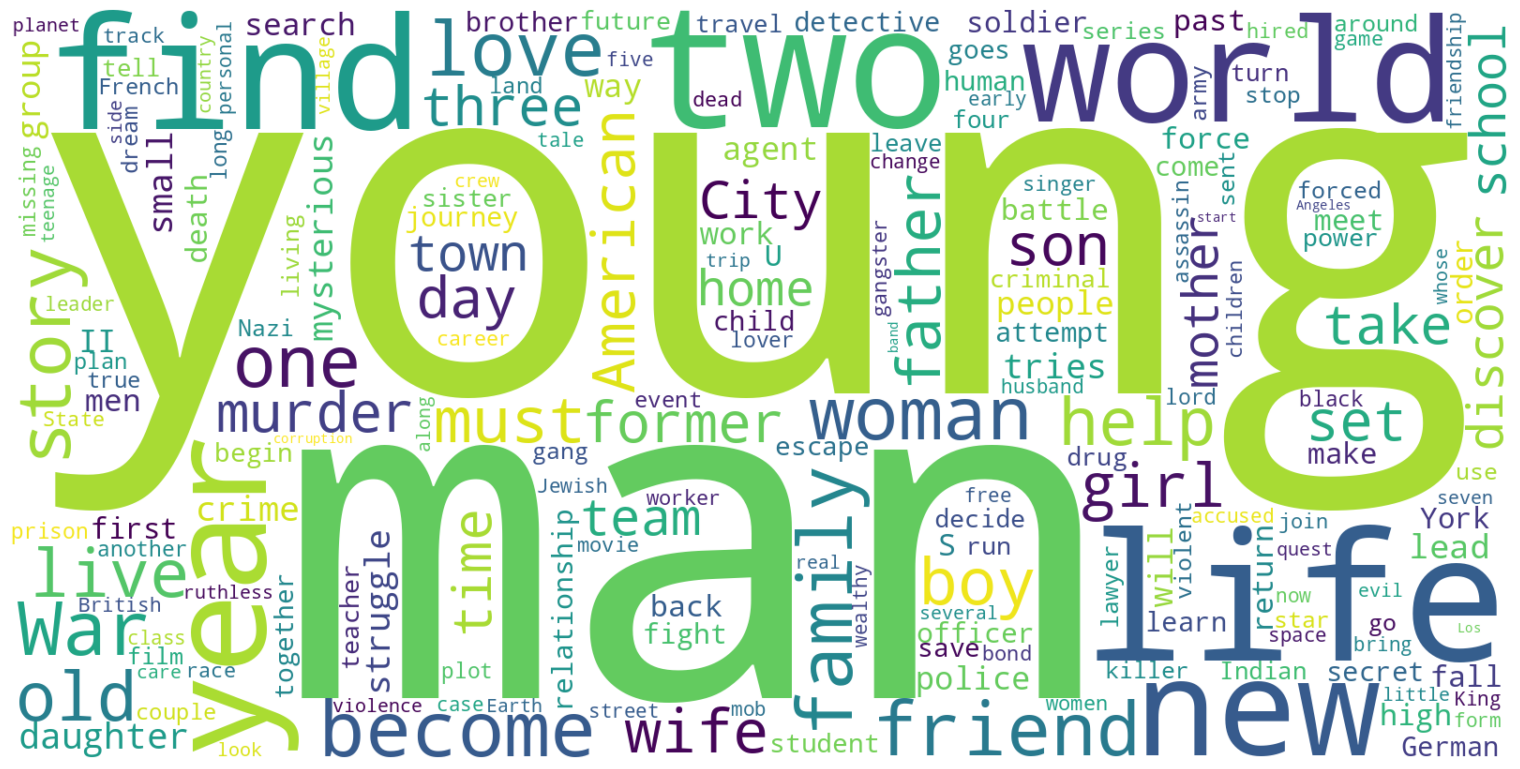

In [52]:
# 3)Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?
# Concatenar todos os resumos da coluna 'Overview' em um único texto
text = " ".join(review for review in df.Overview)

# Criar e gerar a nuvem de palavras geral
# também remove palavras comuns em inglês (como 'the', 'a', 'is') que não trazem muito significado
wordcloud = WordCloud(width=1600, height=800, background_color="white", collocations=False, stopwords=None).generate(text)

# Exibir a imagem gerada
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Remover os eixos
plt.tight_layout(pad=0)
plt.savefig('overview_wordcloud_general.png')
plt.show()

Total de Gêneros Distintos Encontrados: 21
-------------------------------------------------

Gerando nuvens de palavras para 3 gêneros aleatórios...



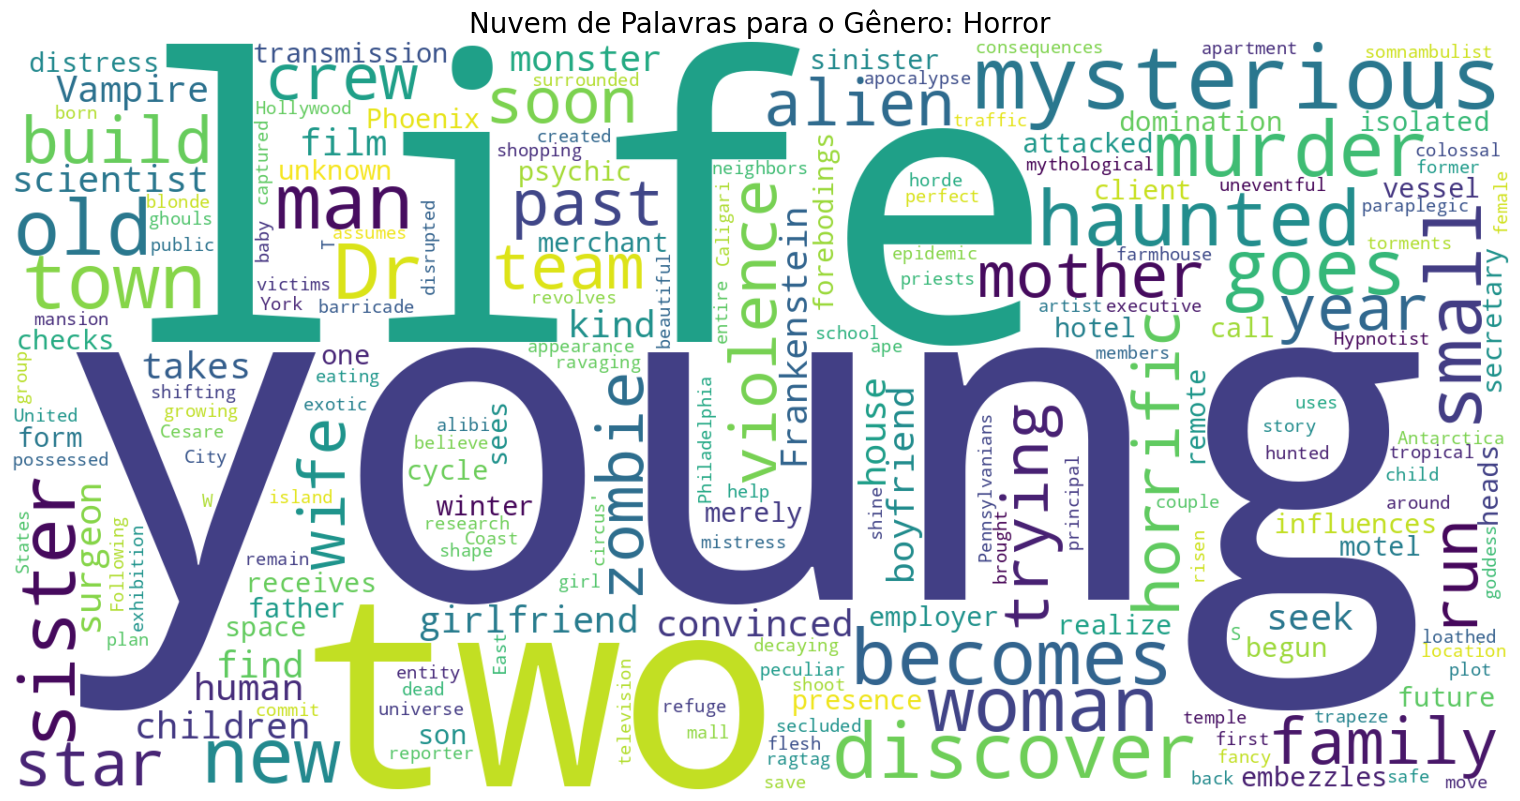

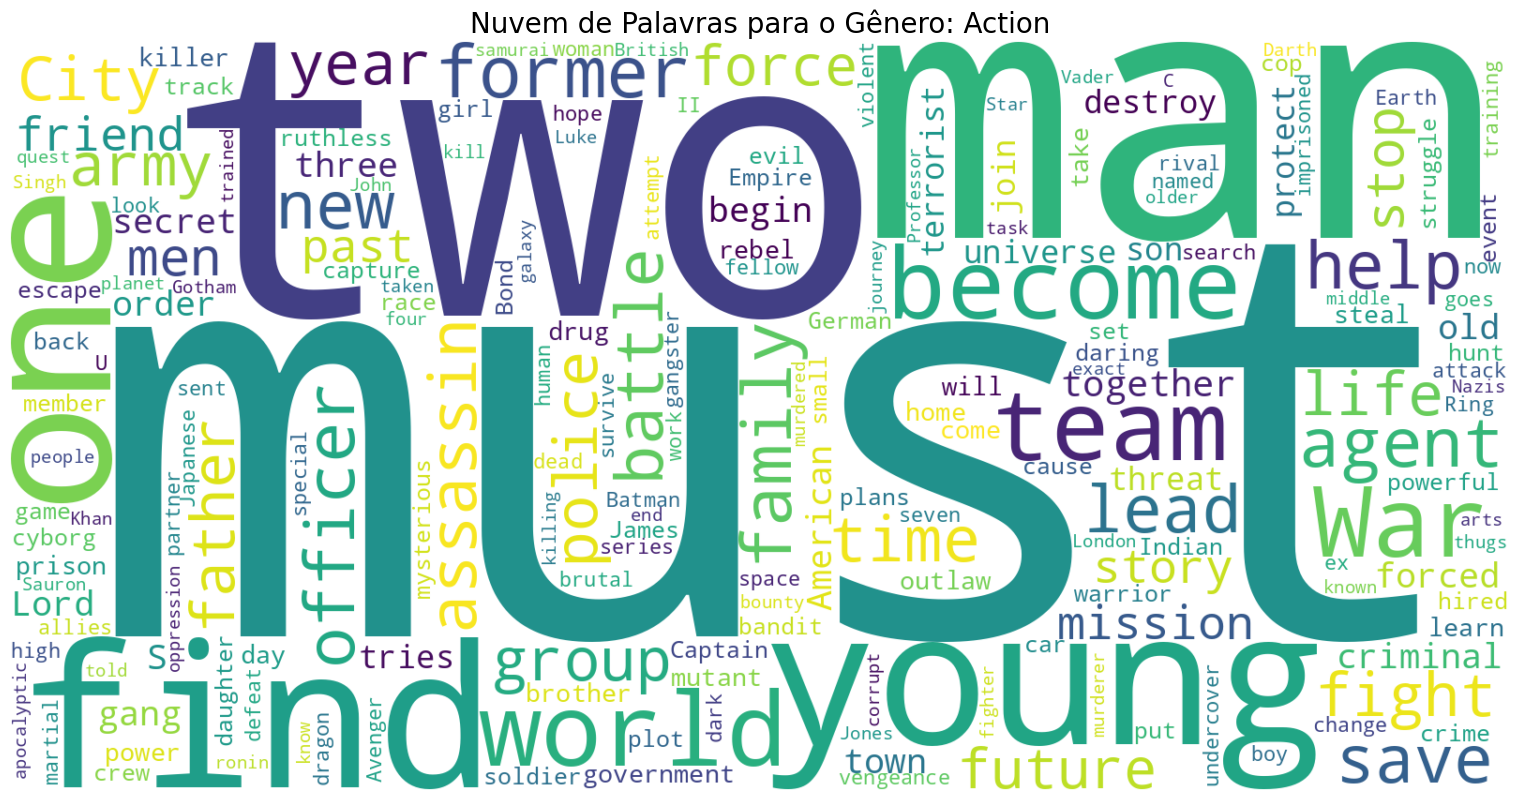

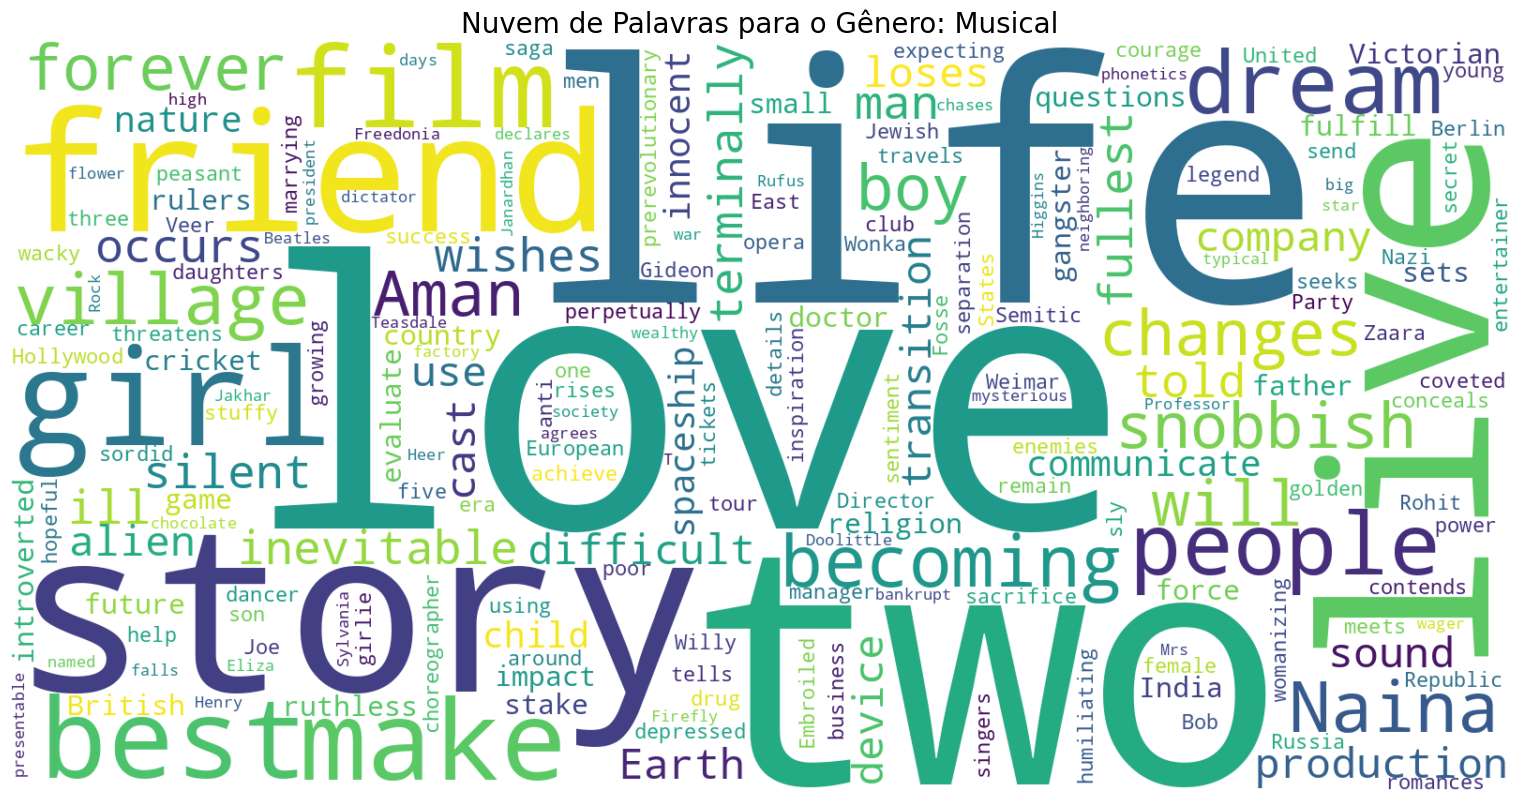

In [53]:
# --- PARTE 1: PESQUISA DE GÊNEROS DISTINTOS

all_genres = df['Genre'].str.split(', ').explode()
unique_genres = all_genres.unique()
print(f"Total de Gêneros Distintos Encontrados: {len(unique_genres)}")
print("-------------------------------------------------\n")


# --- PARTE 2: GERAÇÃO DAS NUVENS DE PALAVRAS

def generate_genre_wordcloud(genre_name):
    genre_df = df[df['Genre'].str.contains(genre_name, na=False)]
    if len(genre_df) == 0:
        print(f"Nenhum filme encontrado para o gênero: {genre_name}")
        return
    text = " ".join(review for review in genre_df.Overview)
    wordcloud = WordCloud(width=1600, height=800, background_color="white", collocations=False, stopwords=None).generate(text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nuvem de Palavras para o Gênero: {genre_name}', fontsize=20)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(f'overview_wordcloud_{genre_name}.png')
    plt.show()

# Gerar nuvens de palavras para os três gêneros selecionados
print("Gerando nuvens de palavras para 3 gêneros aleatórios...\n")
generate_genre_wordcloud('Horror')
generate_genre_wordcloud('Action')
generate_genre_wordcloud('Musical')

In [54]:
print("\n3)Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?")
print ('\nAproveitando a escolha aleatória de 3 gêneros: Horror, Ação e Musical.Pude concluir que pelo agrupamento apresentado, \nque é possível que o resumo possa inferir sobre o gênero, ainda que em alguns casos existam mais de uma classificação \npara um determinado filme.')


3)Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Aproveitando a escolha aleatória de 3 gêneros: Horror, Ação e Musical.Pude concluir que pelo agrupamento apresentado, 
que é possível que o resumo possa inferir sobre o gênero, ainda que em alguns casos existam mais de uma classificação 
para um determinado filme.


Machine Learning

In [55]:
# --- 1. SELEÇÃO DE FEATURES E ALVO ---

# Selecionar as features numéricas
numerical_features = ['Meta_score', 'No_of_Votes', 'Runtime', 'Released_Year']

# Selecionar a feature categórica
categorical_feature = 'Genre'

# Nossa variável alvo (o que queremos prever)
target = 'IMDB_Rating'

# Criar um novo DataFrame apenas com as colunas que nos interessam
df_model = df[numerical_features + [categorical_feature] + [target]].copy()


# --- 2. TRANSFORMAÇÃO DE FEATURES CATEGÓRICAS (ONE-HOT ENCODING) ---

# A coluna 'Genre' pode ter múltiplos valores (ex: "Action, Drama").
# Vamos usar get_dummies para tratar isso corretamente.
# Primeiro, separamos os gêneros
df_genres_expanded = df_model['Genre'].str.get_dummies(sep=', ')

# Juntamos as novas colunas de gênero com as features numéricas
X = pd.concat([df_model[numerical_features], df_genres_expanded], axis=1)

# Nossa variável alvo 'y'
y = df_model[target]


# --- 3. DIVISÃO EM DADOS DE TREINO E TESTE ---

# Dividir os dados em 80% para treino e 20% para teste
# random_state=42 garante a reprodutibilidade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. VERIFICAÇÃO ---
print("Preparação dos dados concluída!")
print("Formato dos dados de treino (X_train):", X_train.shape)
print("Formato dos dados de teste (X_test):", X_test.shape)

Preparação dos dados concluída!
Formato dos dados de treino (X_train): (799, 25)
Formato dos dados de teste (X_test): (200, 25)


In [56]:
# --- 1. CRIAÇÃO E TREINAMENTO DO MODELO ---

# Criar uma instância do modelo RandomForestRegressor
# n_estimators=100 -> número de árvores de decisão
# random_state=42 -> garante a reprodutibilidade
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo
print("Treinando o modelo RandomForest...")
model.fit(X_train, y_train)
print("Treinamento concluído!")


# --- 2. FAZENDO PREVISÕES NO CONJUNTO DE TESTE ---

# Usar o modelo treinado para fazer previsões nos dados de teste
y_pred = model.predict(X_test)


# --- 3. AVALIAÇÃO DO MODELO ---

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)

print("\n--- AVALIAÇÃO DO MODELO BASE ---")
print(f"O Erro Quadrático Médio (MSE) do modelo é: {mse:.4f}")
print(f"A Raiz do Erro Quadrático Médio (RMSE) do modelo é: {rmse:.4f}")

print(f"\nInterpretação: Em média, as previsões do nosso modelo erram a nota do IMDB por aproximadamente {rmse:.4f} pontos.")


# --- 4. SALVANDO O MODELO ---

# Salvar o modelo treinado em um arquivo
filename = 'imdb_rating_predictor.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"\nModelo salvo com sucesso no arquivo: '{filename}'")

Treinando o modelo RandomForest...
Treinamento concluído!

--- AVALIAÇÃO DO MODELO BASE ---
O Erro Quadrático Médio (MSE) do modelo é: 0.0447
A Raiz do Erro Quadrático Médio (RMSE) do modelo é: 0.2114

Interpretação: Em média, as previsões do nosso modelo erram a nota do IMDB por aproximadamente 0.2114 pontos.

Modelo salvo com sucesso no arquivo: 'imdb_rating_predictor.pkl'


In [57]:

# --- 1. CRIAR OS DADOS DO NOVO FILME ---

new_movie_data = {
    'Meta_score': 80.0,
    'No_of_Votes': 2343110,
    'Runtime': 142,
    'Released_Year': 1994,
    'Genre': 'Drama'
}

new_movie_df = pd.DataFrame([new_movie_data])


# --- 2. APLICAR O MESMO PRÉ-PROCESSAMENTO ANTERIOR ---

# Aplicar o One-Hot Encoding para o gênero
new_movie_genres = new_movie_df['Genre'].str.get_dummies(sep=', ')

# Juntar com as features numéricas
new_movie_processed = pd.concat([new_movie_df[['Meta_score', 'No_of_Votes', 'Runtime', 'Released_Year']], new_movie_genres], axis=1)

# Garantir que o novo DataFrame tenha exatamente as mesmas colunas que o X_train, na mesma ordem

final_movie_for_prediction = new_movie_processed.reindex(columns=X_train.columns, fill_value=0)


# --- 3. FAZER A PREVISÃO ---

predicted_rating = model.predict(final_movie_for_prediction)

print("===== PREVISÃO FINAL DO DESAFIO =====")
print(f"\nOs dados do filme fornecido são:")
print(new_movie_data)
print("\n-----------------------------------------")
print(f"A nota do IMDB prevista pelo nosso modelo é: {predicted_rating[0]:.2f}")
print("-----------------------------------------")


===== PREVISÃO FINAL DO DESAFIO =====

Os dados do filme fornecido são:
{'Meta_score': 80.0, 'No_of_Votes': 2343110, 'Runtime': 142, 'Released_Year': 1994, 'Genre': 'Drama'}

-----------------------------------------
A nota do IMDB prevista pelo nosso modelo é: 8.78
-----------------------------------------


In [58]:
# --- 1. SELEÇÃO DE FEATURES PARA O MODELO COM MAIS VARIÁVEIS---

# Usaremos as features de interesse
features = ['Meta_score', 'No_of_Votes', 'Runtime', 'Released_Year', 'Genre', 'Certificate_Simplified', 'Director', 'Star1']
target = 'IMDB_Rating'

df_full_model = df[features + [target]].copy()

# --- 2. DIVISÃO EM TREINO E TESTE
# Isso evita que a informação do conjunto de teste "vaze" para o treino

X = df_full_model.drop(target, axis=1)
y = df_full_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# --- 3. ENGENHARIA DE FEATURES (EM TREINO E TESTE SEPARADAMENTE) ---

# --- Gênero ---
X_train_genres = X_train['Genre'].str.get_dummies(sep=', ')
X_test_genres = X_test['Genre'].str.get_dummies(sep=', ')

# --- Classificação Etária ---
X_train_cert = pd.get_dummies(X_train['Certificate_Simplified'], prefix='Cert')
X_test_cert = pd.get_dummies(X_test['Certificate_Simplified'], prefix='Cert')

# --- Diretor (Top 20 mais frequentes) ---
top_20_directors = X_train['Director'].value_counts().nlargest(20).index
X_train['Director_Encoded'] = X_train['Director'].apply(lambda x: x if x in top_20_directors else 'Other')
X_test['Director_Encoded'] = X_test['Director'].apply(lambda x: x if x in top_20_directors else 'Other')
X_train_director = pd.get_dummies(X_train['Director_Encoded'], prefix='Director')
X_test_director = pd.get_dummies(X_test['Director_Encoded'], prefix='Director')

# --- Ator Principal (Top 20 mais frequentes) ---
top_20_stars = X_train['Star1'].value_counts().nlargest(20).index
X_train['Star1_Encoded'] = X_train['Star1'].apply(lambda x: x if x in top_20_stars else 'Other')
X_test['Star1_Encoded'] = X_test['Star1'].apply(lambda x: x if x in top_20_stars else 'Other')
X_train_star = pd.get_dummies(X_train['Star1_Encoded'], prefix='Star1')
X_test_star = pd.get_dummies(X_test['Star1_Encoded'], prefix='Star1')


# --- 4. COMBINAR TODAS AS FEATURES PROCESSADAS ---

# Separar as features numéricas originais
numerical_features = ['Meta_score', 'No_of_Votes', 'Runtime', 'Released_Year']
X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

# Juntar tudo
X_train_final = pd.concat([X_train_numerical, X_train_genres, X_train_cert, X_train_director, X_train_star], axis=1)
X_test_final = pd.concat([X_test_numerical, X_test_genres, X_test_cert, X_test_director, X_test_star], axis=1)

# Alinhar as colunas - garante que treino e teste tenham exatamente as mesmas colunas
train_cols = X_train_final.columns
test_cols = X_test_final.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0
X_test_final = X_test_final[train_cols]


# --- 5. TREINAR E AVALIAR O NOVO MODELO ---
print("Treinando o 'Modelo Cheio'...")
model_full = RandomForestRegressor(n_estimators=100, random_state=42)
model_full.fit(X_train_final, y_train)
print("Treinamento concluído!")

y_pred_full = model_full.predict(X_test_final)
rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_full))


# --- 6. COMPARAÇÃO E CONCLUSÃO ---
print("\n--- COMPARAÇÃO DOS MODELOS ---")
print(f"RMSE do Modelo de Base: 0.2114")
print(f"RMSE do 'Modelo Cheio': {rmse_full:.4f}")
print("--------------------------------")

if rmse_full < 0.2114:
    print("\nConclusão: O 'Modelo Cheio', com mais variáveis, apresentou um erro menor e é MAIS confiável.")
else:
    print("\nConclusão: O 'Modelo Cheio' não superou o Modelo de Base. O modelo mais simples é mais robusto e confiável, confirmando a hipótese de que mais variáveis nem sempre é melhor.")


Treinando o 'Modelo Cheio'...
Treinamento concluído!

--- COMPARAÇÃO DOS MODELOS ---
RMSE do Modelo de Base: 0.2114
RMSE do 'Modelo Cheio': 0.2064
--------------------------------

Conclusão: O 'Modelo Cheio', com mais variáveis, apresentou um erro menor e é MAIS confiável.


In [59]:
# 1. SALVANDO O "MODELO COM MAIS VARIÁVEIS (full)" EM UM ARQUIVO .pkl

full_model_filename = 'imdb_rating_predictor_full.pkl'
with open(full_model_filename, 'wb') as file:
    pickle.dump(model_full, file)

print(f"Modelo 'Cheio' salvo com sucesso no arquivo: '{full_model_filename}'")


# 2. PREVISÃO PARA OS DADSO DO DESAFIO USANDO O MODELO COM MAIS VARIÁVEIS

print("\n--- Previsão para 'The Shawshank Redemption' ---")

# Criar o dicionário com os dados do filme,fornecidos
shawshank_data = {
    'Meta_score': 80.0,
    'No_of_Votes': 2343110,
    'Runtime': 142,
    'Released_Year': 1994,
    'Genre': 'Drama',
    'Certificate_Simplified': 'Adulto',
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins'
}
shawshank_df = pd.DataFrame([shawshank_data])

# Aplicar a mesma engenharia de features do treino
# Gênero
shawshank_genres = shawshank_df['Genre'].str.get_dummies(sep=', ')
# Certificado
shawshank_cert = pd.get_dummies(shawshank_df['Certificate_Simplified'], prefix='Cert')
# Diretor
shawshank_df['Director_Encoded'] = shawshank_df['Director'].apply(lambda x: x if x in top_20_directors else 'Other')
shawshank_director = pd.get_dummies(shawshank_df['Director_Encoded'], prefix='Director')
# Ator
shawshank_df['Star1_Encoded'] = shawshank_df['Star1'].apply(lambda x: x if x in top_20_stars else 'Other')
shawshank_star = pd.get_dummies(shawshank_df['Star1_Encoded'], prefix='Star1')

# Juntar todas as partes
shawshank_numerical = shawshank_df[['Meta_score', 'No_of_Votes', 'Runtime', 'Released_Year']]
shawshank_processed = pd.concat([shawshank_numerical, shawshank_genres, shawshank_cert, shawshank_director, shawshank_star], axis=1)

# Reindexar para garantir que tenha exatamente as mesmas colunas do X_train_final
shawshank_final = shawshank_processed.reindex(columns=X_train_final.columns, fill_value=0)

# Fazer a previsão
predicted_rating_full = model_full.predict(shawshank_final)

print(f"\nA nota do IMDB prevista pelo 'Modelo Full' é: {predicted_rating_full[0]:.2f}")

# 3. COMPARAÇÃO DE UMA PREVISÃO REAL DO CONJUNTO DE TESTE

print("\n--- Verificação de um Exemplo do Conjunto de Teste ---")

# Pegar o primeiro filme do nosso conjunto de teste para usar como exemplo
example_x = X_test_final.iloc[[0]] # Pega a primeira linha
actual_rating = y_test.iloc[0]    # Pega a nota real correspondente

# Fazer a previsão para este exemplo
example_predicted_rating = model_full.predict(example_x)

print(f"Filme de Exemplo (primeiro filme do conjunto de teste):")
print(f"Nota Prevista pelo Modelo: {example_predicted_rating[0]:.2f}")
print(f"Nota Real (observada): {actual_rating:.2f}")
print(f"Erro da Previsão para este filme: {abs(actual_rating - example_predicted_rating[0]):.2f} pontos")

Modelo 'Cheio' salvo com sucesso no arquivo: 'imdb_rating_predictor_full.pkl'

--- Previsão para 'The Shawshank Redemption' ---

A nota do IMDB prevista pelo 'Modelo Full' é: 8.76

--- Verificação de um Exemplo do Conjunto de Teste ---
Filme de Exemplo (primeiro filme do conjunto de teste):
Nota Prevista pelo Modelo: 7.98
Nota Real (observada): 8.00
Erro da Previsão para este filme: 0.02 pontos


In [60]:
!pip freeze > requirements.txt